
# CubiCasa5k — Doors: Download, Visualize, and COCO Export

This notebook will:
1. **Download** the CubiCasa5k dataset (floorplans with **doors** annotated),
2. **Extract** the archive,
3. **Discover** annotation–image pairs,
4. **Visualize** door **polygons and bounding boxes** on sample images,
5. **Export** a **COCO detection JSON** (doors-only) that you can use to train detectors (Faster R-CNN / YOLO).

> **Note:** Zenodo may require accepting a license in your browser on first access. If the download fails,
> open the link in a browser, accept, then re-run the download cell.



## 0) Install Python dependencies

If you're in a fresh environment, uncomment and run the following cell.


In [ ]:

# !pip install pillow matplotlib opencv-python tqdm requests


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 155.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 182.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 185.1 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
Using cached certifi-2025.8.3-py3-none-any.whl (161 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


## 1) Configuration


In [7]:

from pathlib import Path

ROOT = Path.cwd()
DATA_DIR = ROOT / "cubicasa5k_data"
ZIP_PATH = ROOT / "cubicasa5k.zip"
VIZ_DIR = ROOT / "viz_samples"
COCO_OUT = ROOT / "doors_coco.json"

# How many random visualizations to create
NUM_SAMPLES = 8

# Labels to treat as "door" (some forks may pluralize)
DRAW_CATEGORIES = {"door", "doors"}

# Zenodo mirrors
DOWNLOAD_URLS = [
    "https://zenodo.org/records/2613548/files/cubicasa5k.zip?download=1",
]

DATA_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

print(f"ROOT={ROOT}\nDATA_DIR={DATA_DIR}\nZIP_PATH={ZIP_PATH}\nVIZ_DIR={VIZ_DIR}\nCOCO_OUT={COCO_OUT}")


ROOT=/home/ubuntu/hamid/projs/trunc_tools
DATA_DIR=/home/ubuntu/hamid/projs/trunc_tools/cubicasa5k_data
ZIP_PATH=/home/ubuntu/hamid/projs/trunc_tools/cubicasa5k.zip
VIZ_DIR=/home/ubuntu/hamid/projs/trunc_tools/viz_samples
COCO_OUT=/home/ubuntu/hamid/projs/trunc_tools/doors_coco.json



## 2) Download & Extract


In [8]:

import requests, zipfile
from tqdm import tqdm

def download_file(url: str, out_path: Path, chunk_size: int = 1 << 20) -> bool:
    try:
        with requests.get(url, stream=True, timeout=30) as r:
            r.raise_for_status()
            total = int(r.headers.get("content-length", 0))
            with open(out_path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True, desc=f"Downloading {out_path.name}") as pbar:
                for chunk in r.iter_content(chunk_size=chunk_size):
                    if chunk:
                        f.write(chunk)
                        pbar.update(len(chunk))
        return True
    except Exception as e:
        print(f"[warn] Download failed from {url}: {e}")
        return False

def ensure_zip_present(zip_path: Path, urls) -> None:
    if zip_path.exists():
        print(f"[ok] Found {zip_path.name}")
        return
    print("[info] Attempting to download CubiCasa5k from Zenodo...")
    for url in urls:
        if download_file(url, zip_path):
            print(f"[ok] Downloaded to {zip_path}")
            return
    print(
        "\n[manual action] Could not auto-download.\n"
        "Open this in a browser, accept the license, and place the file here as 'cubicasa5k.zip':\n"
        "  https://zenodo.org/record/2613548\n"
        f"Then re-run this cell. (Expected zip path: {zip_path})\n"
    )
    raise SystemExit(1)

def extract_zip(zip_path: Path, out_dir: Path):
    if any(out_dir.iterdir()):
        print(f"[ok] {out_dir} already contains files.")
        return
    print(f"[info] Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(out_dir)
    print(f"[ok] Extracted to {out_dir}")

# Execute
ensure_zip_present(ZIP_PATH, DOWNLOAD_URLS)
extract_zip(ZIP_PATH, DATA_DIR)


[info] Attempting to download CubiCasa5k from Zenodo...


[ok] Downloaded to /home/ubuntu/hamid/projs/trunc_tools/cubicasa5k.zip
[info] Extracting /home/ubuntu/hamid/projs/trunc_tools/cubicasa5k.zip ...
[ok] Extracted to /home/ubuntu/hamid/projs/trunc_tools/cubicasa5k_data


In [12]:
from pathlib import Path

def show_tree(root: Path, max_depth: int = 3, prefix: str = ""):
    """
    Recursively print a folder tree up to `max_depth` levels deep.
    """
    if max_depth < 0:
        return
    try:
        items = sorted(root.iterdir())
    except Exception as e:
        print(prefix + f"[error opening {root}]: {e}")
        return

    for i, item in enumerate(items):
        connector = "└── " if i == len(items) - 1 else "├── "
        print(prefix + connector + item.name)
        if item.is_dir():
            extension = "    " if i == len(items) - 1 else "│   "
            show_tree(item, max_depth - 1, prefix + extension)

# 👇 Run this with your dataset path
DATA_DIR = Path("/home/ubuntu/hamid/projs/trunc_tools/cubicasa5k_data")
show_tree(DATA_DIR, max_depth=3)

└── cubicasa5k
    ├── colorful
    │   ├── 10052
    │   │   ├── F1_original.png
    │   │   ├── F1_scaled.png
    │   │   └── model.svg
    │   ├── 10062
    │   │   ├── F1_original.png
    │   │   ├── F1_scaled.png
    │   │   └── model.svg
    │   ├── 10106
    │   │   ├── F1_original.png
    │   │   ├── F1_scaled.png
    │   │   ├── F2_original.png
    │   │   ├── F2_scaled.png
    │   │   └── model.svg
    │   ├── 1012
    │   │   ├── F1_original.png
    │   │   ├── F1_scaled.png
    │   │   └── model.svg
    │   ├── 10266
    │   │   ├── F1_original.png
    │   │   ├── F1_scaled.png
    │   │   └── model.svg
    │   ├── 10312
    │   │   ├── F1_original.png
    │   │   ├── F1_scaled.png
    │   │   └── model.svg
    │   ├── 10315
    │   │   ├── F1_original.png
    │   │   ├── F1_scaled.png
    │   │   └── model.svg
    │   ├── 1042
    │   │   ├── F1_original.png
    │   │   ├── F1_scaled.png
    │   │   └── model.svg
    │   ├── 10469
    │   │   ├── F1_original.png
    │   │ 


## 3) Find annotation–image pairs

CubiCasa5k variants place JSON and image files in different folder structures. We search recursively and pick the subfolder with the most pairs.


In [13]:
from pathlib import Path
from typing import List, Tuple

def find_annotation_image_pairs(base_dir: Path) -> List[Tuple[Path, Path]]:
    """
    Find (annotation.svg, image.png) pairs in the CubiCasa5k colorful variant.
    Each sample folder looks like:
        <id>/
          F1_original.png
          F1_scaled.png
          (maybe F2_original.png, F2_scaled.png, ...)
          model.svg
    We pair 'model.svg' with the first available scaled/original PNG.
    """
    pairs = []
    for svg_path in base_dir.rglob("model.svg"):
        folder = svg_path.parent
        # Prefer scaled PNGs, fallback to original
        pngs = sorted(folder.glob("*_scaled.png")) or sorted(folder.glob("*_original.png"))
        if pngs:
            pairs.append((svg_path, pngs[0]))  # take first page image
    return pairs

# Search candidate roots
candidate_roots = [DATA_DIR] + [p for p in DATA_DIR.iterdir() if p.is_dir()]
best_root, best_pairs = None, []
for root in candidate_roots:
    pairs = find_annotation_image_pairs(root)
    if len(pairs) > len(best_pairs):
        best_root, best_pairs = root, pairs

if not best_pairs:
    raise SystemExit(f"[error] No pairs found under {DATA_DIR}. Check extracted structure.")

print(f"[ok] Best root: {best_root}")
print(f"[ok] Found {len(best_pairs)} pairs")
print("Example:", best_pairs[0])

[ok] Best root: /home/ubuntu/hamid/projs/trunc_tools/cubicasa5k_data
[ok] Found 5000 pairs
Example: (PosixPath('/home/ubuntu/hamid/projs/trunc_tools/cubicasa5k_data/cubicasa5k/high_quality/9362/model.svg'), PosixPath('/home/ubuntu/hamid/projs/trunc_tools/cubicasa5k_data/cubicasa5k/high_quality/9362/F1_scaled.png'))


In [ ]:
import xml.etree.ElementTree as ET
from pathlib import Path

def collect_svg_labels(svg_path):
    """Extract all labels (id/class/label/inkscape:label) from one SVG file."""
    labels = []
    tree = ET.parse(svg_path)
    root = tree.getroot()

    for g in root.iter():
        ids   = g.get("id", "")
        cls   = g.get("class", "")
        lab1  = g.attrib.get("label", "")
        lab2  = g.attrib.get("{http://www.inkscape.org/namespaces/inkscape}label", "")
        for val in [ids, cls, lab1, lab2]:
            if val:
                labels.append(val.lower())

    return labels


# ---- Run over your dataset ----
all_labels = set()
svg_files = [p for (p, _) in best_pairs]   # assuming best_pairs = (svg_path, img_path)

for svg in svg_files[:100]:  # limit to first 100 to start
    all_labels.update(collect_svg_labels(svg))

print(f"Found {len(all_labels)} unique labels:\n")
for lbl in sorted(all_labels):
    print(lbl)

0024c262-d8e2-448f-978f-e6672cd0c197
002ec442-1baf-4bce-93a6-3e1182769f64
0033fce5-a521-4a51-aaaf-1f6f685783fe
0036a4b6-55fc-4aaf-9079-cf6cac06e908
005a5e12-5533-4a1a-9e7a-eb2f3fe0fca9
00c0b592-ee94-4312-b8c3-8aa9a61da46d
01b4cd52-6785-4c2b-98af-1bc995bad2f2
022eb0f4-bb70-4005-9d8f-93810c303773
0282c738-ffd5-4724-bb34-f5fa456ff12a
03274dee-0e6f-4699-ba44-9334901f9f3f
03635e53-90fd-4145-9116-a8a9c98d6efb
03905eae-ad70-4017-8a68-6c67c81c75f8
03911f68-2ad4-49e0-a359-fbe793ce655d
03de9df1-cb3b-4c3c-8e6b-c6b5fb2b5a22
040b6522-1327-45d8-aa6f-6c18372107e8
04eb59c5-5bf3-46d2-bb96-80a9e01a1c08
0575e86c-5711-434d-8b02-cf6953bb8c5f
0592996c-3197-43aa-9959-2c52f8dd9173
05b0b0d7-71b9-422f-b0bc-50d9b2c0e4ff
06a23f32-9540-4e62-989f-c325343f596c
06a58b13-98c9-4e7f-a05f-fbbbd3f95e55
06ad92c1-6272-476e-839c-0c1bfb90652f
06d9facb-2dd7-4288-85ac-511a96353e86
06feec95-309a-4b9c-9a5f-f37893b04e42
074c039f-4a6e-48e7-ab71-006202a9ac2e
075edc2e-fa56-49b1-aafd-80bf5e481e06
07b59b43-92fc-4919-b5f9-e753f46a4709
0


## 4) Visualize doors (polygons + bboxes)


In [14]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

def polygon_to_bbox(poly):
    xs = [p[0] for p in poly]; ys = [p[1] for p in poly]
    return [min(xs), min(ys), max(xs), max(ys)]  # x1,y1,x2,y2

def draw_polygon(ax, poly, color=(0,1,0), lw=2):
    xs = [p[0] for p in poly] + [poly[0][0]]
    ys = [p[1] for p in poly] + [poly[0][1]]
    ax.plot(xs, ys, linewidth=lw, color=color)

def visualize_sample(img_path: Path, ann: Dict[str, Any], draw_cats=DRAW_CATEGORIES):
    im = np.array(Image.open(img_path).convert("RGB"))
    fig = plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.imshow(im)
    ax.set_axis_off()

    green, magenta = (0,1,0), (1,0,1)
    objects = ann.get("objects", ann.get("annotations", []))
    doors_drawn = 0

    for obj in objects:
        label = (obj.get("label") or obj.get("category") or "").lower()
        if label not in draw_cats:
            continue
        poly = obj.get("polygon") or obj.get("points") or obj.get("segmentation")
        if isinstance(poly, dict) and "points" in poly:
            poly = poly["points"]
        if isinstance(poly, list) and len(poly) >= 3 and isinstance(poly[0], (list, tuple)):
            bbox = polygon_to_bbox(poly)
            # polygon
            draw_polygon(ax, poly, color=green, lw=2)
            # bbox
            x1,y1,x2,y2 = bbox
            ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=2, edgecolor=magenta))
            doors_drawn += 1

    ax.set_title(f"{img_path.name} — doors: {doors_drawn}")
    fig.tight_layout()
    return fig, doors_drawn



### Run visualization on random samples
This will display them inline *and* save PNGs under `viz_samples/`.


In [18]:
import xml.etree.ElementTree as ET

svg_path, img_path = best_pairs[0]  # pick first sample
tree = ET.parse(svg_path)
root = tree.getroot()

print("Inspecting:", svg_path)
for elem in root.iter():
    # Print the first ~20 elements with their tag + attributes
    print(elem.tag, elem.attrib)
    # stop early to avoid spamming
    if len(elem.attrib) > 0 and any("door" in v.lower() for v in elem.attrib.values()):
        print(">>> FOUND potential door:", elem.attrib)
        break

Inspecting: /home/ubuntu/hamid/projs/trunc_tools/cubicasa5k_data/cubicasa5k/high_quality/9362/model.svg
{http://www.w3.org/2000/svg}svg {'height': '1269.0298919677734', 'version': '1.1', 'width': '2835.25', 'id': 'temp', 'viewBox': '0 0 2835.25 1269.0298919677734'}
{http://www.w3.org/2000/svg}desc {}
{http://www.w3.org/2000/svg}defs {}
{http://www.w3.org/2000/svg}g {'id': 'Model', 'class': 'Model v1-1'}
{http://www.w3.org/2000/svg}g {'class': 'Floor'}
{http://www.w3.org/2000/svg}g {'id': 'Floor-1', 'transform': 'matrix(1,0,0,1,0,0)', 'class': 'Floorplan Floor-1'}
{http://www.w3.org/2000/svg}g {'id': 'edf081fc-bee8-4505-a610-36930af92a64', 'class': 'Space Undefined', 'fill': '#ffffff', 'stroke': '#ffffff', 'style': 'fill-opacity: 1; stroke-opacity: 1; stroke-width: 0.2;'}
{http://www.w3.org/2000/svg}polygon {'points': '586.52,750.39 466.53,750.39 466.53,611.05 586.52,611.05 '}
{http://www.w3.org/2000/svg}g {'transform': 'matrix(1,0,0,1,466.5327,611.0509)', 'class': 'Dimension'}
{http://

In [19]:
import xml.etree.ElementTree as ET

def find_labels(svg_path, keywords=("door", "window", "opening")):
    tree = ET.parse(svg_path)
    root = tree.getroot()
    hits = []
    for elem in root.iter():
        attrs = " ".join([f"{k}={v}" for k,v in elem.attrib.items()])
        if any(kw in attrs.lower() for kw in keywords):
            hits.append((elem.tag, elem.attrib))
    return hits

svg_path, img_path = best_pairs[0]  # pick one
hits = find_labels(svg_path, keywords=("door",))
print(f"File: {svg_path}\nFound {len(hits)} door-tagged elements")
for tag, attrib in hits[:10]:  # show only first 10
    print(tag, attrib)

File: /home/ubuntu/hamid/projs/trunc_tools/cubicasa5k_data/cubicasa5k/high_quality/9362/model.svg
Found 16 door-tagged elements
{http://www.w3.org/2000/svg}g {'id': '2260fb2a-5d5b-4a5d-8971-a59ba298ddc0', 'class': 'Space Outdoor', 'fill': '#ffffff', 'stroke': '#000000', 'style': 'stroke-width: 0.2; fill-opacity: 1; stroke-opacity: 1;'}
{http://www.w3.org/2000/svg}g {'id': 'Door', 'fill': '#ffffff', 'stroke': '#000000', 'style': 'fill-opacity: 1; stroke-width: 1; stroke-opacity: 1;', 'class': 'Door Swing Beside'}
{http://www.w3.org/2000/svg}g {'id': 'Door', 'fill': '#ffffff', 'stroke': '#000000', 'style': 'fill-opacity: 1; stroke-width: 1; stroke-opacity: 1;', 'class': 'Door Swing Beside'}
{http://www.w3.org/2000/svg}g {'id': 'Door', 'fill': '#ffffff', 'stroke': '#000000', 'style': 'fill-opacity: 1; stroke-width: 1; stroke-opacity: 1;', 'class': 'Door Swing Beside'}
{http://www.w3.org/2000/svg}g {'id': 'Door', 'fill': '#ffffff', 'stroke': '#000000', 'style': 'fill-opacity: 1; stroke-wid

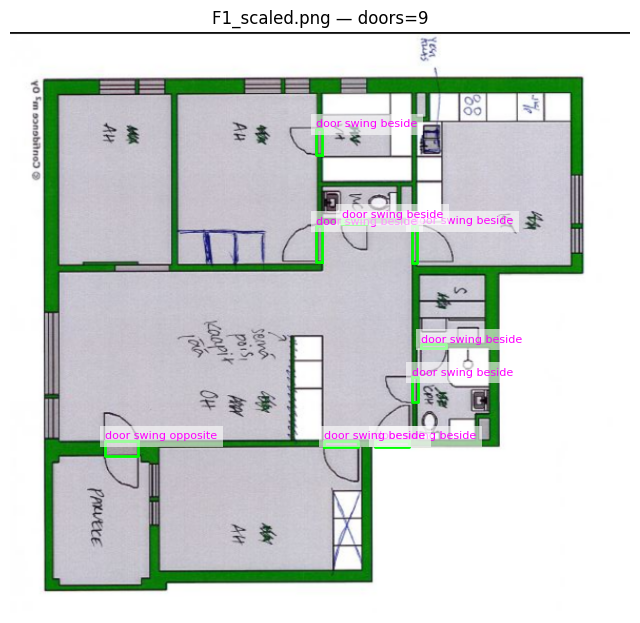

[ok] Saved /home/ubuntu/hamid/projs/trunc_tools/viz_samples/sample_01_F1_scaled.png (doors=9)


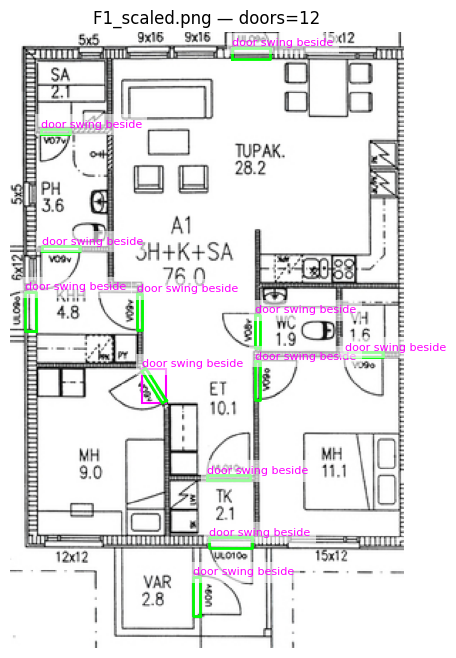

[ok] Saved /home/ubuntu/hamid/projs/trunc_tools/viz_samples/sample_02_F1_scaled.png (doors=12)


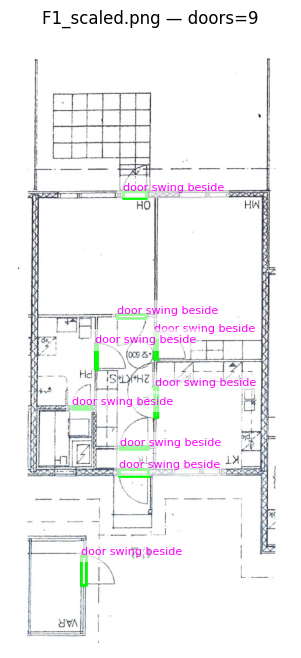

[ok] Saved /home/ubuntu/hamid/projs/trunc_tools/viz_samples/sample_03_F1_scaled.png (doors=9)


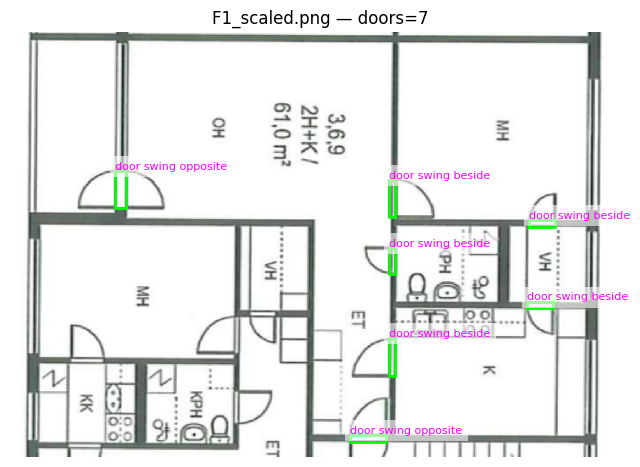

[ok] Saved /home/ubuntu/hamid/projs/trunc_tools/viz_samples/sample_04_F1_scaled.png (doors=7)


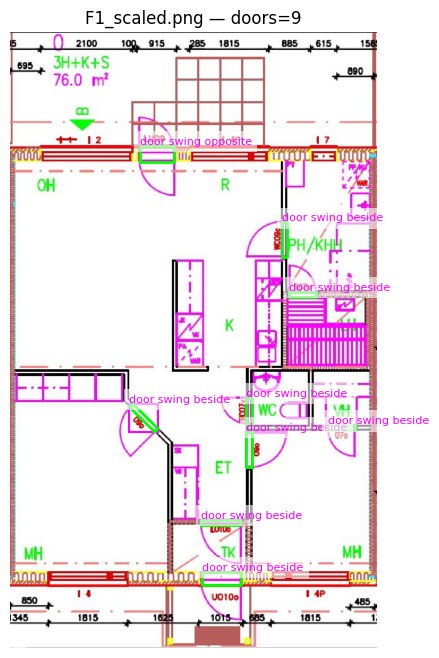

[ok] Saved /home/ubuntu/hamid/projs/trunc_tools/viz_samples/sample_05_F1_scaled.png (doors=9)


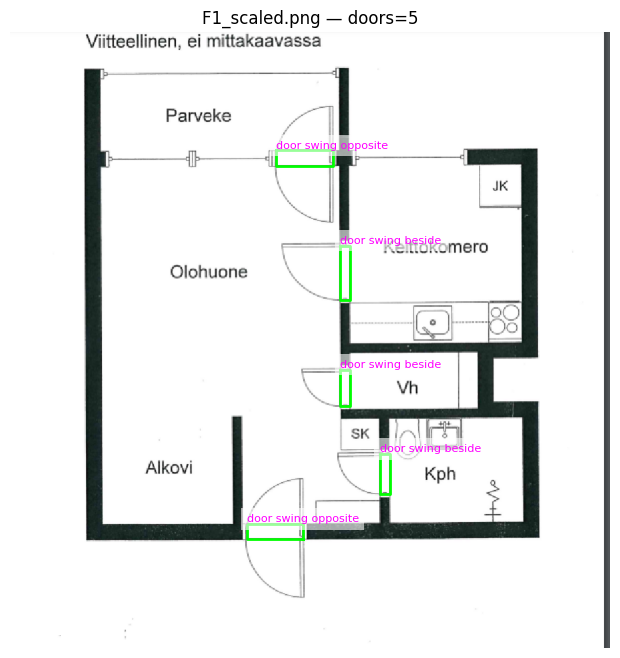

[ok] Saved /home/ubuntu/hamid/projs/trunc_tools/viz_samples/sample_06_F1_scaled.png (doors=5)


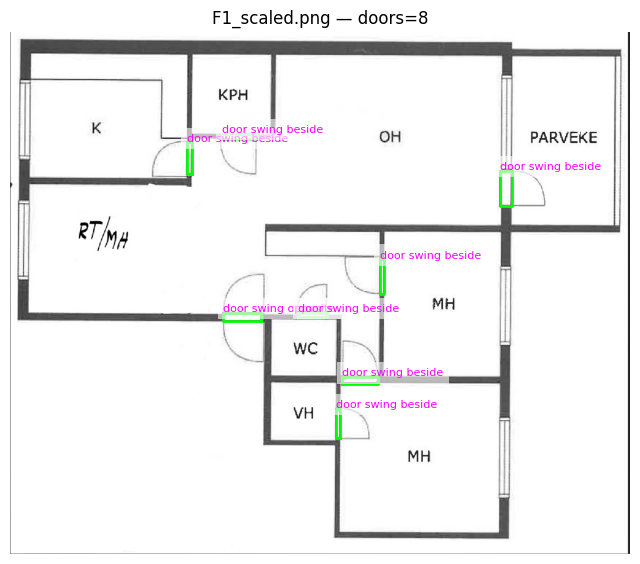

[ok] Saved /home/ubuntu/hamid/projs/trunc_tools/viz_samples/sample_07_F1_scaled.png (doors=8)


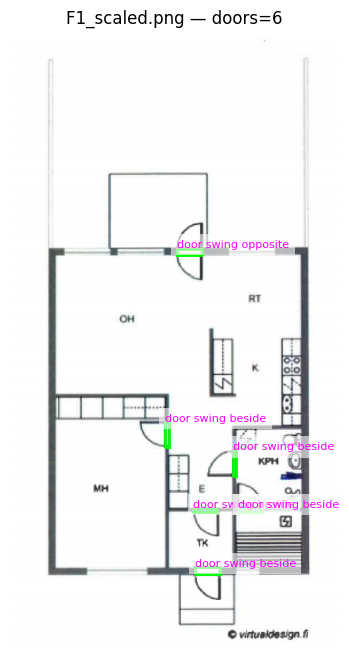

[ok] Saved /home/ubuntu/hamid/projs/trunc_tools/viz_samples/sample_08_F1_scaled.png (doors=6)

Done. Shown 8 samples that contain doors. Saved under /home/ubuntu/hamid/projs/trunc_tools/viz_samples.


In [ ]:
import random
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from shapely.geometry import Polygon

# ✅ your door labels (case-insensitive, matched as substrings)
DOOR_LABELS = {
    #"door",
    "door none beside",
    "door parallelslide beside",
    "door rollup beside",
    "door slide beside",
    "door swing beside",
    "door swing opposite",
    "door zfold beside",
    #"doors",
}

def _match_door_label(label_text: str):
    """Return the first matching door label (substring match), else None."""
    lt = label_text.lower()
    for lab in DOOR_LABELS:
        if lab in lt:
            return lab
    return None

def parse_svg_doors(svg_path):
    """
    Parse model.svg and return a list of dicts:
      { 'poly': [(x,y),...], 'label': '<matched door label>' }
    Only polygons/rects inside <g> whose attributes contain one of DOOR_LABELS.
    """
    tree = ET.parse(svg_path)
    root = tree.getroot()
    doors = []

    for g in root.iter():
        labels = [
            g.get("id", ""),
            g.get("class", ""),
            g.attrib.get("{http://www.inkscape.org/namespaces/inkscape}label", ""),
            g.attrib.get("label", "")
        ]
        joined = " ".join([s for s in labels if s])
        matched = _match_door_label(joined)
        if not matched:
            continue

        # collect polygons/rects inside this group
        for elem in g:
            if elem.tag.endswith("polygon"):
                pts = elem.attrib.get("points", "")
                poly = []
                for p in pts.strip().split():
                    if "," in p:
                        x, y = map(float, p.split(","))
                        poly.append((x, y))
                if poly:
                    doors.append({"poly": poly, "label": matched})

            elif elem.tag.endswith("rect"):
                x = float(elem.attrib.get("x", 0))
                y = float(elem.attrib.get("y", 0))
                w = float(elem.attrib.get("width", 0))
                h = float(elem.attrib.get("height", 0))
                poly = [(x,y), (x+w,y), (x+w,y+h), (x,y+h)]
                doors.append({"poly": poly, "label": matched})

    return doors

def _box_from_points(poly, min_area=1.0, pad_if_small=4.0):
    """Axis-aligned bbox with padding if the polygon is degenerate/small."""
    xs = [p[0] for p in poly]
    ys = [p[1] for p in poly]
    x1, y1, x2, y2 = min(xs), min(ys), max(xs), max(ys)

    # use polygon area when possible
    if len(poly) >= 3:
        shp = Polygon(poly)
        if shp.is_valid and shp.area >= min_area:
            minx, miny, maxx, maxy = shp.bounds
            return minx, miny, maxx, maxy

    # degenerate (line/point): make a small padded box
    return x1 - pad_if_small, y1 - pad_if_small, x2 + pad_if_small, y2 + pad_if_small

def visualize_sample(img_path, door_objs):
    """Overlay door polygons + labeled bboxes."""
    im = np.array(Image.open(img_path).convert("RGB"))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(im)
    ax.set_axis_off()

    for d in door_objs:
        poly = d["poly"]
        label = d["label"]

        # polygon (green)
        xs = [p[0] for p in poly] + [poly[0][0]]
        ys = [p[1] for p in poly] + [poly[0][1]]
        ax.plot(xs, ys, color="lime", linewidth=2)

        # bbox (magenta) + label
        minx, miny, maxx, maxy = _box_from_points(poly, min_area=4.0, pad_if_small=6.0)
        ax.add_patch(plt.Rectangle((minx, miny), maxx-minx, maxy-miny,
                                   fill=False, edgecolor="magenta", linewidth=1.5))
        ax.text(minx, max(miny-3, 0), label, fontsize=8,
                color="magenta", bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    ax.set_title(f"{img_path.name} — doors={len(door_objs)}")
    return fig, len(door_objs)

# ---- Run visualization (only samples with doors) ----
sample_pairs = best_pairs[:]  # list of (svg_path, img_path)
random.shuffle(sample_pairs)

door_counts = []
shown = 0
for i, (svg_path, img_path) in enumerate(sample_pairs, 1):
    door_objs = parse_svg_doors(svg_path)
    if not door_objs:
        continue  # skip if no doors

    fig, n = visualize_sample(img_path, door_objs)
    door_counts.append(n)
    out_path = VIZ_DIR / f"sample_{shown+1:02d}_{img_path.stem}.png"
    fig.savefig(out_path, dpi=180)
    plt.show()
    print(f"[ok] Saved {out_path} (doors={n})")

    shown += 1
    if shown >= NUM_SAMPLES:
        break

print(f"\nDone. Shown {shown} samples that contain doors. Saved under {VIZ_DIR}.")


## 5) Export COCO detection JSON (doors only)

This cell builds `doors_coco.json` with one category (`door=1`) and bounding boxes derived from polygons.


In [31]:

import json
import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image

# ── your chosen door labels (case-insensitive substring match)
DOOR_LABELS = {
    # "door",                 # ← intentionally excluded
    "door none beside",
    "door parallelslide beside",
    "door rollup beside",
    "door slide beside",
    "door swing beside",
    "door swing opposite",
    "door zfold beside",
    # "doors",                # ← intentionally excluded
}

def _match_door_label(text: str) -> bool:
    t = text.lower()
    return any(lbl in t for lbl in DOOR_LABELS)

def _door_polys_from_svg(svg_path: Path):
    """
    Return list of polygons for doors found in model.svg based on DOOR_LABELS.
    Each item is a list of (x,y) floats.
    """
    tree = ET.parse(svg_path)
    root = tree.getroot()
    out = []

    # Find <g> groups whose id/class/labels match our whitelist
    for g in root.iter():
        labels = [
            g.get("id", ""),
            g.get("class", ""),
            g.attrib.get("{http://www.inkscape.org/namespaces/inkscape}label", ""),
            g.attrib.get("label", ""),
        ]
        if not _match_door_label(" ".join([s for s in labels if s])):
            continue

        # collect door geometry inside the group
        for elem in g:
            tag = elem.tag.split("}")[-1]  # strip namespace
            if tag == "polygon":
                pts = elem.attrib.get("points", "")
                poly = []
                for tok in pts.strip().split():
                    if "," in tok:
                        x, y = tok.split(",")
                        poly.append((float(x), float(y)))
                if poly:
                    out.append(poly)
            elif tag == "rect":
                x = float(elem.attrib.get("x", 0))
                y = float(elem.attrib.get("y", 0))
                w = float(elem.attrib.get("width", 0))
                h = float(elem.attrib.get("height", 0))
                poly = [(x,y), (x+w,y), (x+w,y+h), (x,y+h)]
                out.append(poly)
            # (optional) you could add simple <line> → tiny box handling here
    return out

def _bbox_from_points(poly, pad=4.0, min_wh=2.0):
    xs = [p[0] for p in poly]
    ys = [p[1] for p in poly]
    x1, y1, x2, y2 = min(xs), min(ys), max(xs), max(ys)
    w, h = x2 - x1, y2 - y1
    # pad degenerate / very thin shapes so the box isn't zero-sized
    if w < min_wh: 
        x1 -= pad; x2 += pad; w = x2 - x1
    if h < min_wh: 
        y1 -= pad; y2 += pad; h = y2 - y1
    return x1, y1, w, h

def export_coco_doors_from_svg(
    pairs,                      # iterable of (svg_path, img_path)
    coco_out: Path,
    max_images: int = 1000,     # cap to 1000 images with at least one door
):
    images, annotations = [], []
    cat_map = {"door": 1}
    image_id = 1
    ann_id = 1
    kept = 0

    for svg_path, img_path in pairs:
        # parse doors in this svg
        door_polys = _door_polys_from_svg(svg_path)
        if not door_polys:
            continue  # skip images without doors

        # open image to get size
        try:
            with Image.open(img_path) as im:
                im = im.convert("RGB")
                width, height = im.size
        except Exception as e:
            print(f"[skip img open] {img_path}: {e}")
            continue

        images.append({
            "id": image_id,
            "file_name": str(img_path),
            "width": width,
            "height": height,
        })

        for poly in door_polys:
            x, y, w, h = _bbox_from_points(poly, pad=4.0, min_wh=2.0)
            if w <= 1 or h <= 1:
                continue
            annotations.append({
                "id": ann_id,
                "image_id": image_id,
                "category_id": cat_map["door"],
                "bbox": [float(x), float(y), float(w), float(h)],
                "area": float(w*h),
                "iscrowd": 0,
            })
            ann_id += 1

        kept += 1
        image_id += 1
        if kept >= max_images:
            break

    coco = {
        "info": {"description": "CubiCasa5k Doors (COCO bbox, SVG parsed, filtered labels)", "version": "1.0", "year": 2025},
        "licenses": [],
        "images": images,
        "annotations": annotations,
        "categories": [{"id": 1, "name": "door", "supercategory": "object"}],
    }

    coco_out.parent.mkdir(parents=True, exist_ok=True)
    with open(coco_out, "w") as f:
        json.dump(coco, f)
    print(f"[ok] Wrote {coco_out} with {len(images)} images and {len(annotations)} door boxes.")

# ---- Build a 1000-image dataset (only images that contain doors) ----
# best_pairs must be a list of (svg_path, img_path) discovered earlier.
# Optionally shuffle to randomize which 1000 are kept.
import random
pairs_shuffled = best_pairs[:]
random.shuffle(pairs_shuffled)

COCO_OUT = Path("doors_coco_1000.json")
export_coco_doors_from_svg(pairs_shuffled, COCO_OUT, max_images=1000)


/home/ubuntu/hamid/.conda/lib/python3.11/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90344064 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ok] Wrote doors_coco_1000.json with 1000 images and 10098 door boxes.
